In [6]:
# Download dataset from following link: https://drive.google.com/file/d/1DxSOyloRyd4q_kx6YpPwlrbjanmKaSWS/view
# Extract zip file into same directory of this notebook file

## Binary Classifier on Dataset (imported from HW1)

In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
import pandas as pd
import numpy as np

from datetime import datetime
import os

from tensorflow.python.client import device_lib
import tensorflow as tf
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4451500226068026013
xla_global_id: -1
]


In [4]:
# Setup
fold_num = 1

# Image Size
img_width, img_height, img_depth = 128, 128, 3
data_dir = Path('content/Data_Small')
data_dir_train = data_dir / 'train'

epochs = 10
freq = 20
batch_size = 40
num_classes = 2
train_valid_split = 0.2

class_weights = {0: 2.,
                1: 1.,
                2: 1.}

if num_classes < 2:
    act_type = 'sigmoid'
    class_mode = 'binary'
    loss_fun = 'binary_crossentropy'
else:
    act_type = 'softmax'
    class_mode = 'categorical'
    loss_fun = 'categorical_crossentropy'
print('Type of classification: ', class_mode)
print('Loss function: ', loss_fun)
print('Activation function: ', act_type)

Type of classification:  categorical
Loss function:  categorical_crossentropy
Activation function:  softmax


*Explanation of hyperparameters*

Epochs: I first trained with 5 max epochs, which resulted in cutting off the max learning potential (loss was still decreasing). Increased to 10, which resulted in reaching close to absolute minimum.

Learning rate: Based on the example code given, I used the same learning rate as it performed well for this case based on the loss plot below. It may have been possible to get a smoother loss descent with a smaller learning rate, but that would require much more epochs.

Batch Size: With the default batch size of 32, my training worked well but the loss plot was quite eratic. Since I had more VRAM available, I increased the batch size to allow the calculated loss to encapsulate more data samples.

### 2: Data

In [5]:
img_height = 128
img_width = 128

# # Method 1: image_dataset_from_directory
# data_dir_DME = Path('/content/Data_Small/train/')
# train_df = tf.keras.utils.image_dataset_from_directory(
#     data_dir_DME,
#     validation_split=0.2,
#     subset="training",
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )
# val_df = tf.keras.utils.image_dataset_from_directory(
#     data_dir_DME,
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )

# Method 2: ImageDataGenerator
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 90,
    validation_split = 0.2,
    fill_mode = 'constant')

train_generator = datagen.flow_from_directory(
    directory = '/content/Data_Small/train/',
    class_mode = class_mode,
    batch_size = batch_size,
    target_size = (img_height, img_width),
    subset = "training")

valid_generator = datagen.flow_from_directory(
    directory = '/content/Data_Small/train/',
    class_mode = class_mode,
    batch_size = batch_size,
    target_size = (img_height, img_width),
    subset = "validation",
    shuffle = False)

Found 2028 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


In [6]:
class_names = train_generator.class_indices
print(class_names)

{'DME': 0, 'DRUSEN': 1}


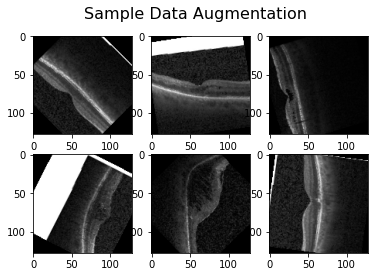

y Labels:  [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
sample img, max value:  1.0
sample img, min value:  0.0


In [7]:
#For Directory
#Preview the augmented data
X_preview, y_preview = train_generator.next()

for k in range(1,7):
    sample_img = X_preview[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize = 16)    
plt.show()

print('y Labels: ', y_preview[1:5])
print('sample img, max value: ',np.max(sample_img))
print('sample img, min value: ',np.min(sample_img))

### 3: Training

##### Train your model using

In [22]:
# To prevent dataset bottleneck, keep images in memory and 
#   preprocess data while executing model during training
# AUTOTUNE = tf.data.AUTOTUNE
# train_df = train_df.cache().prefetch(buffer_size=AUTOTUNE)
# val_df = val_df.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
gdrive_dir = '/content/gdrive/MyDrive/Biomed AI'

In [11]:
# Build model
image_input = Input(shape = (img_width, img_height, img_depth))
base_model = applications.vgg16.VGG16(input_tensor = image_input,
                                      include_top = False,
                                      weights = 'imagenet')
base_output = base_model.layers[-1].output

flat1 = Flatten()(base_output)
fc1 = Dense(8192, activation = 'relu')(flat1)
dropfc1 = Dropout(0.5)(fc1)
fc2 = Dense(4096, activation = 'relu')(dropfc1)
dropfc2 = Dropout(0.5)(fc2)

output = Dense(num_classes, activation = act_type)(dropfc2)

for layer in base_model.layers[:-9]:
  layer.trainable = False

model = Model(image_input, output)

58889256/58889256 [==============================] - 3s 0us/step


In [12]:
# Compile the model
opt = Adam(learning_rate = 0.00001)
model.compile(loss = loss_fun, optimizer = opt, metrics = ['accuracy'])

In [13]:
from dummy_threading import current_thread
# Folder setup
init_time = datetime.now()
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = 'trained_models_' + current_time + '_fold_num' + str(fold_num)
os.mkdir(name_dir)

# Callbacks1: ModelCheckpointer
model_file_format = name_dir + '/model_' + str(fold_num) + '_model.{epoch:04d}.hdf5'
check = ModelCheckpoint(model_file_format, period = freq, verbose = 1)

# Callbacks2: TensorBoard
tensor_check = './logs/' + current_time + '_train_testsplit' + str(fold_num)
tensor_board = TensorBoard(tensor_check)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
# Plot model
figure_name = name_dir + '/model_output.png'
plot_model(model, figure_name, show_shapes = True)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [14]:
history = model.fit_generator(train_generator,
                              epochs = epochs,
                              steps_per_epoch = train_generator.samples // batch_size,
                              validation_data = valid_generator,
                              validation_steps = valid_generator.samples // batch_size,
                              callbacks = [check, tensor_board],
                              class_weight = class_weights)

early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
model.save_weights(early_stop_name)
hist_df = pd.DataFrame(history.history)

<ipython-input-14-8f503a8aa9a4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
50/50 [==============================] - 30s 378ms/step - loss: 1.0535 - accuracy: 0.5865 - val_loss: 0.7017 - val_accuracy: 0.6292
Epoch 2/10
50/50 [==============================] - 15s 304ms/step - loss: 0.8883 - accuracy: 0.6408 - val_loss: 0.5264 - val_accuracy: 0.6896
Epoch 3/10
50/50 [==============================] - 15s 307ms/step - loss: 0.5985 - accuracy: 0.7731 - val_loss: 0.3512 - val_accuracy: 0.8396
Epoch 4/10
50/50 [==============================] - 17s 350ms/step - loss: 0.4015 - accuracy: 0.8778 - val_loss: 0.3630 - val_accuracy: 0.8583
Epoch 5/10
50/50 [==============================] - 15s 306ms/step - loss: 0.3128 - accuracy: 0.8954 - val_loss: 0.1993 - val_accuracy: 0.9187
Epoch 6/10
50/50 [==============================] - 15s 303ms/step - loss: 0.2880 - accuracy: 0.9054 - val_loss: 0.1816 - val_accuracy: 0.9250
Epoch 7/10
50/50 [==============================] - 19s 372ms/step - loss: 0.2640 - accuracy: 0.9140 - val_loss: 0.2587 - val_accuracy: 0.8958

In [15]:
model.save('/content/gdrive/MyDrive/Biomed AI/10epoch_model')

In [16]:
# Save history
# np.save('10epoch_hist.npy', history.history)
# history.history
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('/content/gdrive/MyDrive/Biomed AI/10epoch_hist.csv')

In [8]:
# # Load Model
# model = tf.keras.models.load_model('/content/gdrive/MyDrive/Biomed AI/10epoch_model')
# model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [10]:
# # Plot training and validation loss
# stats_df = pd.read_csv('/content/gdrive/MyDrive/Biomed AI/10epoch_hist.csv')
# stats_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,1.045777,0.583501,0.857778,0.629167
1,1,0.918416,0.620221,0.722819,0.633333
2,2,0.623900,0.761066,0.376969,0.825000
3,3,0.418422,0.866197,0.346826,0.870833
4,4,0.324159,0.894869,0.212213,0.908333
5,5,0.295158,0.906439,0.266612,0.897917
6,6,0.272669,0.915493,0.201055,0.914583
7,7,0.240861,0.926056,0.255602,0.908333
8,8,0.231335,0.926056,0.183989,0.920833
9,9,0.217301,0.930583,0.246455,0.889583


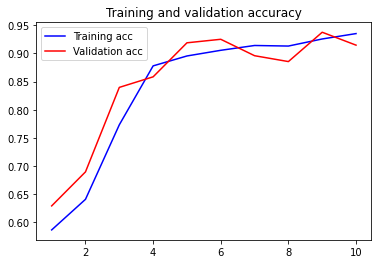

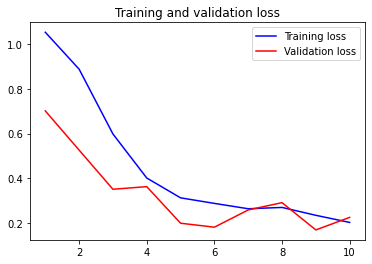

In [19]:
# Assign each loss/accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Confusion Matrix

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes#[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [21]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.2,
    rotation_range = 90,
    fill_mode = 'constant')

test_generator = test_datagen.flow_from_directory(
                              directory = '/content/Data_Small/train',
                              target_size = (img_width, img_height),
                              class_mode = class_mode,
                              batch_size = batch_size)
X, y_true = [], []
i = 0
while i < 30:
    temp_X, temp_y_true = test_generator.next()
    if i < 1:
        X = temp_X
        y_true = temp_y_true
    else:
        X = np.concatenate((X, temp_X), axis=0)
        y_true = np.concatenate((y_true, temp_y_true), axis = 0)
    i += 1

print(np.shape(X))
print(np.shape(y_true))

y_pred = model.predict(X)

Found 2534 images belonging to 2 classes.
(1200, 128, 128, 3)
(1200, 2)
38/38 [==============================] - 4s 75ms/step


Categorical Classification
---------------------
Normalized confusion matrix
[[0.98314607 0.01685393]
 [0.16188525 0.83811475]]
[[700  12]
 [ 79 409]]


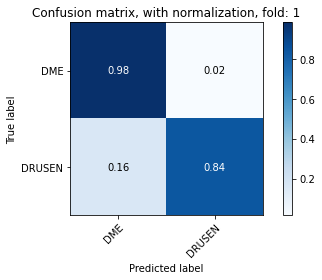

In [23]:
title_mat = 'Confusion matrix, with normalization, fold: ' + str(fold_num)
plot_name = name_dir + '/confusion_matrix_fold' + str(fold_num) + '.png'
print('Categorical Classification')
print('---------------------')
plot_confusion_matrix(y_true.argmax(axis=1),
                      y_pred.argmax(axis=1),
                      classes = class_names,
                      normalize = True,
                      title = title_mat)
plt.savefig(plot_name)
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

## Testing GAN

In [15]:
# import libraries
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
# Generate some data to use as baseline
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

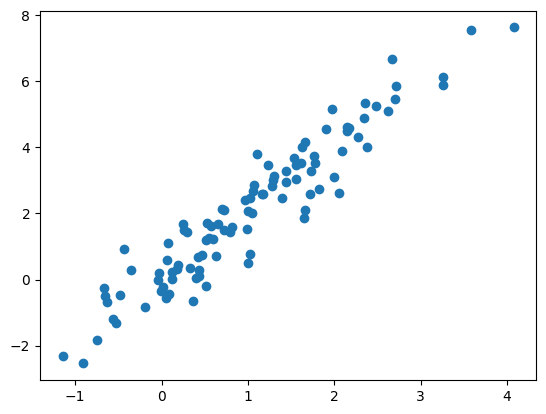

In [11]:
plt.scatter(data[:100, 0].detach().numpy(), data[:100, 1].detach().numpy())

In [8]:
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, output_size)
        self.act = nn.Tanh()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 1)
        self.act = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        return x

In [9]:
class GAN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.gen = Generator(input_size, output_size)
        self.dis = Discriminator(output_size)
    
    def forward(self, x):
        x = self.gen(x)
        x = self.dis(x)
        return x

In [27]:
# Define discriminator loss function
def disLoss(real, fake):
    loss = nn.BCELoss()
    realLoss = loss(real, torch.ones_like(real))
    fakeLoss = loss(fake, torch.zeros_like(fake))
    return realLoss + fakeLoss

In [11]:
# Generator loss function
def genLoss(fake):
    loss = nn.BCELoss()
    return loss(fake, torch.ones_like(fake))

In [34]:
def trainGAN(gan, disOptimizer, genOptimizer, data_size, batch_size, num_epochs):
    losses = {'Discriminator': [], 'Generator': []}
    for epoch in tqdm(range(num_epochs)):
        for i in range(0, data_size, batch_size):
            # Generate random data
            y = torch.randn(batch_size, 10)
            
            # Generate fake data with ground truths
            fakeData = gan.gen(y)
            
            realData = torch.randn(batch_size, 10)
            realOutput = gan.dis(realData)
            fakeOutput = gan.dis(fakeData.detach())
            
            dis_loss = disLoss(realOutput, fakeOutput)
            disOptimizer.zero_grad()
            dis_loss.backward()
            disOptimizer.step()
            
            y = torch.randn(batch_size, 10)
            fakeData = gan.gen(y)
            
            fakeOutput = gan.dis(fakeData)
            gen_loss = genLoss(fakeOutput)
            genOptimizer.zero_grad()
            gen_loss.backward()
            genOptimizer.step()
        
        dis_loss_epoch = dis_loss.item() / (data_size // batch_size)
        gen_loss_epoch = gen_loss.item() / (data_size // batch_size)
        losses['Discriminator'].append(dis_loss_epoch)
        losses['Generator'].append(gen_loss_epoch)
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'
                  .format(epoch+1, num_epochs, dis_loss_epoch, gen_loss_epoch))
        
    return losses

In [16]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [25]:
disOptim = torch.optim.Adam(Discriminator(10).parameters(), lr=0.001)
genOptim = torch.optim.Adam(Generator(10, 10).parameters(), lr=0.001)

data = torch.randn(1000, 10)
batch_size = 32
dataset = CustomDataset(data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [35]:
num_epochs = 100
data_size = len(dataset)
gan = GAN(10, 10)
train_loss = trainGAN(gan, disOptim, genOptim, data_size, batch_size, num_epochs)

 12%|█████████▋                                                                       | 12/100 [00:00<00:03, 22.61it/s]

Epoch [10/100], Discriminator Loss: 0.0456, Generator Loss: 0.0289


 24%|███████████████████▍                                                             | 24/100 [00:01<00:03, 22.43it/s]

Epoch [20/100], Discriminator Loss: 0.0461, Generator Loss: 0.0289


 33%|██████████████████████████▋                                                      | 33/100 [00:01<00:02, 22.55it/s]

Epoch [30/100], Discriminator Loss: 0.0461, Generator Loss: 0.0289


 42%|██████████████████████████████████                                               | 42/100 [00:01<00:02, 22.77it/s]

Epoch [40/100], Discriminator Loss: 0.0457, Generator Loss: 0.0289


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:02<00:02, 22.62it/s]

Epoch [50/100], Discriminator Loss: 0.0449, Generator Loss: 0.0289


 63%|███████████████████████████████████████████████████                              | 63/100 [00:02<00:01, 22.65it/s]

Epoch [60/100], Discriminator Loss: 0.0451, Generator Loss: 0.0289


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:03<00:01, 22.78it/s]

Epoch [70/100], Discriminator Loss: 0.0453, Generator Loss: 0.0290


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:03<00:00, 22.95it/s]

Epoch [80/100], Discriminator Loss: 0.0454, Generator Loss: 0.0290


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:04<00:00, 22.93it/s]

Epoch [90/100], Discriminator Loss: 0.0460, Generator Loss: 0.0289


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.65it/s]

Epoch [100/100], Discriminator Loss: 0.0457, Generator Loss: 0.0289


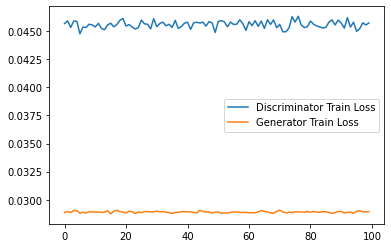

In [36]:
plt.plot(train_loss['Discriminator'], label='Discriminator Train Loss')
plt.plot(train_loss['Generator'], label='Generator Train Loss')
plt.legend()
plt.show()

## SRGAN

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from datetime import datetime
from torchvision.utils import save_image
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from torchvision.models import vgg19
from tqdm import tqdm
from torch.autograd import Variable
from torch.nn import functional as F
import torchvision.transforms.functional as TF

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Import dataset and scale images down to 32x32
class RetinaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['DME', 'DRUSEN']
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.images = []
        self.labels = []

        for cls_name in self.classes:
            cls_path = os.path.join(self.root_dir, 'train', cls_name)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.images.append(img_path)
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_filename = self.images[index]
        label = self.labels[index]
        # Load the high-resolution image
        hr_img = Image.open(img_filename).convert('RGB')
        hr_transform = transforms.Resize((128, 128))
        hr_img_128 = hr_transform(hr_img)
        
        # Apply a transform to generate the low-resolution image
        lr_transform = transforms.Resize((32, 32))
        lr_img = lr_transform(hr_img)
        
        if self.transform:
            lr_img = self.transform(lr_img)
            hr_img_128 = self.transform(hr_img_128)
            
        return lr_img, hr_img_128

In [13]:
# Define the SRGAN generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Feature extraction
        self.conv1 = nn.Conv2d(3, 64, 9, 1, 4)
        self.relu1 = nn.PReLU()

        # Upsampling
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pixshuffle = nn.PixelShuffle(2)
        self.relu2 = nn.PReLU()

        self.conv3 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pixshuffle2 = nn.PixelShuffle(2)
        self.relu3 = nn.PReLU()

        # Reconstruction
        self.conv4 = nn.Conv2d(64, 3, 9, 1, 4)

    def forward(self, x):
        out = self.relu1(self.conv1(x))

        residual = out

        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.relu3(self.bn3(self.conv3(out)))
        
        # DEBUG
        # print(f'Out shape: {out.shape}')
        # print(f'Residual shape: {residual.shape}')
        out += residual
        
        out = self.conv4(out)

        return out

# Define the SRGAN discriminator network
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, features, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(features, features, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(features, features*2, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(features*2)
        self.conv4 = nn.Conv2d(features*2, features*2, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(features*2, features*4, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(features*4)
        self.conv6 = nn.Conv2d(features*4, features*4, kernel_size=3, stride=2, padding=1)
        self.conv7 = nn.Conv2d(features*4, features*8, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(features*8)
        self.conv8 = nn.Conv2d(features*8, features*8, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(features*8*8*8, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.lrelu(self.conv1(x))
        out = self.lrelu(self.conv2(out))
        out = self.lrelu(self.bn3(self.conv3(out)))
        out = self.lrelu(self.conv4(out))
        out = self.lrelu(self.bn5(self.conv5(out)))
        out = self.lrelu(self.conv6(out))
        out = self.lrelu(self.bn7(self.conv7(out)))
        out = self.lrelu(self.conv8(out))
        out = out.view(out.size(0), -1)
        out = self.lrelu(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        
        return out

In [14]:
# Define Loss Functions
criterion_GAN = nn.BCELoss()
criterion_content = nn.MSELoss()

generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [15]:
# # Set hyperparameters
batch_size = 16
num_epochs = 100
# lr = 0.0002
# b1 = 0.5
# b2 = 0.999

SRGAN_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

octDataset = RetinaDataset('Data', transform=SRGAN_transform)
# Split training and validation set
oct_train, oct_val = random_split(octDataset, [0.7, 0.3])
trainLoader = DataLoader(oct_train, batch_size=batch_size, shuffle=True)
valLoader = DataLoader(oct_val, batch_size=1, shuffle=False)

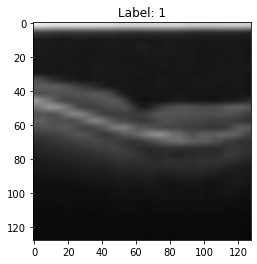

In [16]:
low_res, high_res = octDataset[11000]
label = octDataset.labels[11000]
# Convert the PyTorch tensor to a NumPy array and transpose the dimensions
low_res = low_res.numpy().transpose(1, 2, 0)
high_res = high_res.numpy().transpose(1, 2, 0)

# Display the image using matplotlib
plt.imshow(low_res)
# plt.imshow(high_res)
plt.title(f"Label: {label}")
plt.show()

In [17]:
def imshow(img):
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

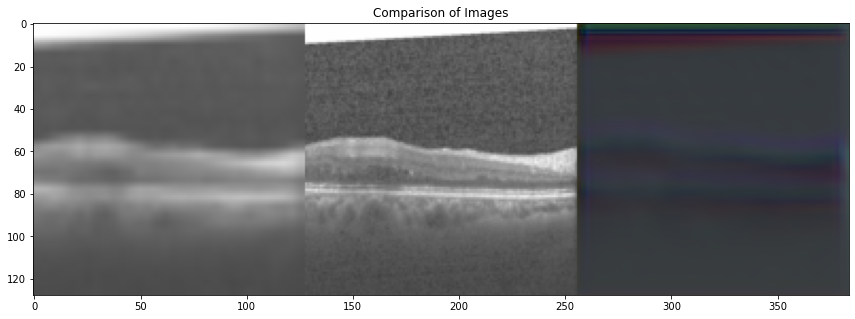

Generator(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (relu1): PReLU(num_parameters=1)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pixshuffle): PixelShuffle(upscale_factor=2)
  (relu2): PReLU(num_parameters=1)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pixshuffle2): PixelShuffle(upscale_factor=2)
  (relu3): PReLU(num_parameters=1)
  (conv4): Conv2d(64, 3, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
)

In [19]:
generator.eval()
# for i, (lr_images, hr_images) in enumerate(valLoader):
lr_image, hr_image = next(iter(valLoader))
lr_image_ex = lr_image.to(device)
hr_image_ex = hr_image.to(device)

sr_image = generator(lr_image_ex)
example_image = torch.cat([lr_image_ex, hr_image_ex, sr_image], dim=3)
example_image = make_grid(example_image, normalize=True, scale_each=True)
example_image = np.transpose(example_image.cpu().detach().numpy(), (1, 2, 0))
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
axs.imshow(example_image)
axs.set_title('Comparison of Images')
plt.show()
generator.train()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Batch [1/837], Generator Loss: 0.6741, Discriminator Loss: 0.7000
Epoch [1/100], Batch [101/837], Generator Loss: 29.1402, Discriminator Loss: 0.1110
Epoch [1/100], Batch [201/837], Generator Loss: 18.7347, Discriminator Loss: 0.0000
Epoch [1/100], Batch [301/837], Generator Loss: 24.7117, Discriminator Loss: 0.0000
Epoch [1/100], Batch [401/837], Generator Loss: 13.4491, Discriminator Loss: 0.0000
Epoch [1/100], Batch [501/837], Generator Loss: 100.0076, Discriminator Loss: 50.0000
Epoch [1/100], Batch [601/837], Generator Loss: 100.0068, Discriminator Loss: 50.0000
Epoch [1/100], Batch [701/837], Generator Loss: 100.0067, Discriminator Loss: 50.0000
Epoch [1/100], Batch [801/837], Generator Loss: 100.0057, Discriminator Loss: 50.0000


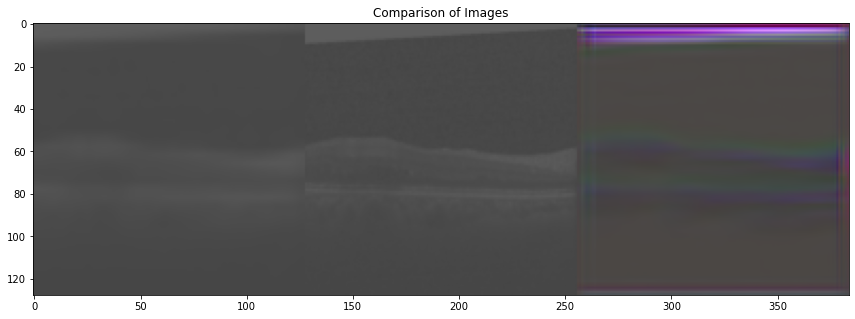

  1%|▊                                                                              | 1/100 [03:09<5:13:04, 189.74s/it]

Epoch [2/100], Batch [1/837], Generator Loss: 100.0056, Discriminator Loss: 50.0000
Epoch [2/100], Batch [101/837], Generator Loss: 100.0052, Discriminator Loss: 50.0000
Epoch [2/100], Batch [201/837], Generator Loss: 100.0048, Discriminator Loss: 50.0000
Epoch [2/100], Batch [301/837], Generator Loss: 100.0044, Discriminator Loss: 50.0000
Epoch [2/100], Batch [401/837], Generator Loss: 100.0038, Discriminator Loss: 50.0000
Epoch [2/100], Batch [501/837], Generator Loss: 100.0034, Discriminator Loss: 50.0000
Epoch [2/100], Batch [601/837], Generator Loss: 100.0036, Discriminator Loss: 50.0000
Epoch [2/100], Batch [701/837], Generator Loss: 100.0028, Discriminator Loss: 50.0000
Epoch [2/100], Batch [801/837], Generator Loss: 100.0025, Discriminator Loss: 50.0000


  2%|█▌                                                                             | 2/100 [06:13<5:03:58, 186.11s/it]

Epoch [3/100], Batch [1/837], Generator Loss: 100.0023, Discriminator Loss: 50.0000
Epoch [3/100], Batch [101/837], Generator Loss: 100.0025, Discriminator Loss: 50.0000
Epoch [3/100], Batch [201/837], Generator Loss: 100.0023, Discriminator Loss: 50.0000
Epoch [3/100], Batch [301/837], Generator Loss: 100.0023, Discriminator Loss: 50.0000
Epoch [3/100], Batch [401/837], Generator Loss: 100.0014, Discriminator Loss: 50.0000
Epoch [3/100], Batch [501/837], Generator Loss: 100.0019, Discriminator Loss: 50.0000
Epoch [3/100], Batch [601/837], Generator Loss: 100.0015, Discriminator Loss: 50.0000
Epoch [3/100], Batch [701/837], Generator Loss: 100.0015, Discriminator Loss: 50.0000
Epoch [3/100], Batch [801/837], Generator Loss: 100.0013, Discriminator Loss: 50.0000


  3%|██▎                                                                            | 3/100 [09:14<4:57:11, 183.83s/it]

Epoch [4/100], Batch [1/837], Generator Loss: 100.0017, Discriminator Loss: 50.0000
Epoch [4/100], Batch [101/837], Generator Loss: 100.0013, Discriminator Loss: 50.0000
Epoch [4/100], Batch [201/837], Generator Loss: 100.0011, Discriminator Loss: 50.0000
Epoch [4/100], Batch [301/837], Generator Loss: 100.0013, Discriminator Loss: 50.0000
Epoch [4/100], Batch [401/837], Generator Loss: 100.0010, Discriminator Loss: 50.0000
Epoch [4/100], Batch [501/837], Generator Loss: 100.0009, Discriminator Loss: 50.0000
Epoch [4/100], Batch [601/837], Generator Loss: 100.0010, Discriminator Loss: 50.0000
Epoch [4/100], Batch [701/837], Generator Loss: 100.0008, Discriminator Loss: 50.0000
Epoch [4/100], Batch [801/837], Generator Loss: 100.0007, Discriminator Loss: 50.0000


  4%|███▏                                                                           | 4/100 [12:15<4:52:33, 182.85s/it]

Epoch [5/100], Batch [1/837], Generator Loss: 100.0008, Discriminator Loss: 50.0000
Epoch [5/100], Batch [101/837], Generator Loss: 100.0008, Discriminator Loss: 50.0000
Epoch [5/100], Batch [201/837], Generator Loss: 100.0007, Discriminator Loss: 50.0000
Epoch [5/100], Batch [301/837], Generator Loss: 100.0007, Discriminator Loss: 50.0000
Epoch [5/100], Batch [401/837], Generator Loss: 100.0006, Discriminator Loss: 50.0000
Epoch [5/100], Batch [501/837], Generator Loss: 100.0006, Discriminator Loss: 50.0000
Epoch [5/100], Batch [601/837], Generator Loss: 100.0006, Discriminator Loss: 50.0000
Epoch [5/100], Batch [701/837], Generator Loss: 100.0006, Discriminator Loss: 50.0000
Epoch [5/100], Batch [801/837], Generator Loss: 100.0005, Discriminator Loss: 50.0000


  5%|███▉                                                                           | 5/100 [15:16<4:48:34, 182.26s/it]

Epoch [6/100], Batch [1/837], Generator Loss: 100.0005, Discriminator Loss: 50.0000
Epoch [6/100], Batch [101/837], Generator Loss: 100.0005, Discriminator Loss: 50.0000
Epoch [6/100], Batch [201/837], Generator Loss: 100.0004, Discriminator Loss: 50.0000
Epoch [6/100], Batch [301/837], Generator Loss: 100.0004, Discriminator Loss: 50.0000
Epoch [6/100], Batch [401/837], Generator Loss: 100.0005, Discriminator Loss: 50.0000
Epoch [6/100], Batch [501/837], Generator Loss: 100.0004, Discriminator Loss: 50.0000
Epoch [6/100], Batch [601/837], Generator Loss: 100.0004, Discriminator Loss: 50.0000
Epoch [6/100], Batch [701/837], Generator Loss: 100.0004, Discriminator Loss: 50.0000
Epoch [6/100], Batch [801/837], Generator Loss: 100.0004, Discriminator Loss: 50.0000


  6%|████▋                                                                          | 6/100 [18:18<4:44:58, 181.90s/it]

Epoch [7/100], Batch [1/837], Generator Loss: 100.0004, Discriminator Loss: 50.0000
Epoch [7/100], Batch [101/837], Generator Loss: 100.0003, Discriminator Loss: 50.0000
Epoch [7/100], Batch [201/837], Generator Loss: 100.0004, Discriminator Loss: 50.0000
Epoch [7/100], Batch [301/837], Generator Loss: 100.0003, Discriminator Loss: 50.0000
Epoch [7/100], Batch [401/837], Generator Loss: 100.0003, Discriminator Loss: 50.0000
Epoch [7/100], Batch [501/837], Generator Loss: 100.0003, Discriminator Loss: 50.0000
Epoch [7/100], Batch [601/837], Generator Loss: 100.0003, Discriminator Loss: 50.0000
Epoch [7/100], Batch [701/837], Generator Loss: 100.0003, Discriminator Loss: 50.0000
Epoch [7/100], Batch [801/837], Generator Loss: 100.0003, Discriminator Loss: 50.0000


  7%|█████▌                                                                         | 7/100 [21:20<4:41:55, 181.88s/it]

Epoch [8/100], Batch [1/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [8/100], Batch [101/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [8/100], Batch [201/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [8/100], Batch [301/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [8/100], Batch [401/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [8/100], Batch [501/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [8/100], Batch [601/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [8/100], Batch [701/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [8/100], Batch [801/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000


  8%|██████▎                                                                        | 8/100 [24:20<4:38:10, 181.42s/it]

Epoch [9/100], Batch [1/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [9/100], Batch [101/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [9/100], Batch [201/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [9/100], Batch [301/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [9/100], Batch [401/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [9/100], Batch [501/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [9/100], Batch [601/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [9/100], Batch [701/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [9/100], Batch [801/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000


  9%|███████                                                                        | 9/100 [27:23<4:35:49, 181.86s/it]

Epoch [10/100], Batch [1/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [10/100], Batch [101/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [10/100], Batch [201/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [10/100], Batch [301/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [10/100], Batch [401/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [10/100], Batch [501/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [10/100], Batch [601/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [10/100], Batch [701/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [10/100], Batch [801/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000


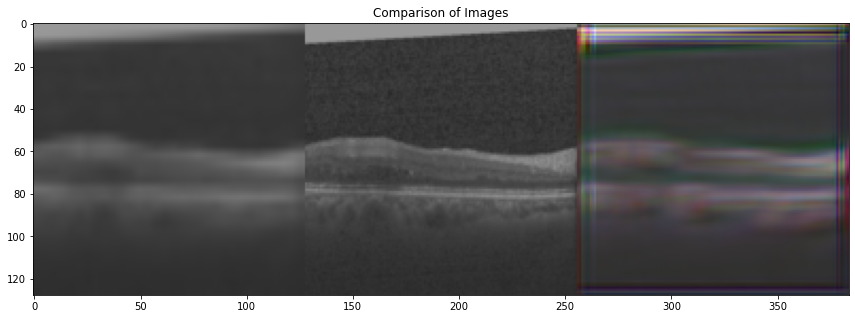

 10%|███████▊                                                                      | 10/100 [30:24<4:32:29, 181.66s/it]

Epoch [11/100], Batch [1/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [11/100], Batch [101/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [11/100], Batch [201/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [11/100], Batch [301/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [11/100], Batch [401/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [11/100], Batch [501/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [11/100], Batch [601/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [11/100], Batch [701/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [11/100], Batch [801/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000


 11%|████████▌                                                                     | 11/100 [33:25<4:29:06, 181.42s/it]

Epoch [12/100], Batch [1/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [12/100], Batch [101/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [12/100], Batch [201/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [12/100], Batch [301/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [12/100], Batch [401/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [12/100], Batch [501/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [12/100], Batch [601/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [12/100], Batch [701/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [12/100], Batch [801/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000


 12%|█████████▎                                                                    | 12/100 [36:28<4:26:51, 181.95s/it]

Epoch [13/100], Batch [1/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [13/100], Batch [101/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [13/100], Batch [201/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [13/100], Batch [301/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [13/100], Batch [401/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [13/100], Batch [501/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [13/100], Batch [601/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [13/100], Batch [701/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [13/100], Batch [801/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000


 13%|██████████▏                                                                   | 13/100 [39:29<4:23:28, 181.71s/it]

Epoch [14/100], Batch [1/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [14/100], Batch [101/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [14/100], Batch [201/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [14/100], Batch [301/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [14/100], Batch [401/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [14/100], Batch [501/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [14/100], Batch [601/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [14/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [14/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 14%|██████████▉                                                                   | 14/100 [42:38<4:23:23, 183.76s/it]

Epoch [15/100], Batch [1/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [15/100], Batch [101/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [15/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [15/100], Batch [301/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [15/100], Batch [401/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [15/100], Batch [501/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [15/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [15/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [15/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 15%|███████████▋                                                                  | 15/100 [45:51<4:24:26, 186.67s/it]

Epoch [16/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [16/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [16/100], Batch [201/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [16/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [16/100], Batch [401/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [16/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [16/100], Batch [601/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [16/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [16/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 16%|████████████▍                                                                 | 16/100 [49:01<4:22:53, 187.79s/it]

Epoch [17/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [17/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [17/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [17/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [17/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [17/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [17/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [17/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [17/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 17%|█████████████▎                                                                | 17/100 [52:11<4:20:34, 188.37s/it]

Epoch [18/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [18/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [18/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [18/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [18/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [18/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [18/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [18/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [18/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 18%|██████████████                                                                | 18/100 [55:21<4:17:57, 188.74s/it]

Epoch [19/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [19/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [19/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [19/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [19/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [19/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [19/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [19/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [19/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 19%|██████████████▊                                                               | 19/100 [58:31<4:15:19, 189.13s/it]

Epoch [20/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [20/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [20/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [20/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [20/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [20/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [20/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [20/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [20/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


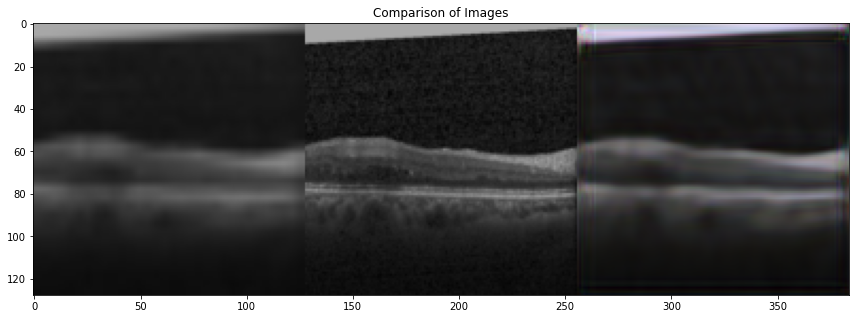

 20%|███████████████▏                                                            | 20/100 [1:01:42<4:13:04, 189.80s/it]

Epoch [21/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [21/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [21/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [21/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [21/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [21/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [21/100], Batch [601/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [21/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [21/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 21%|███████████████▉                                                            | 21/100 [1:04:50<4:09:08, 189.23s/it]

Epoch [22/100], Batch [1/837], Generator Loss: 100.0004, Discriminator Loss: 50.0000
Epoch [22/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [22/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [22/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [22/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [22/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [22/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [22/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [22/100], Batch [801/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000


 22%|████████████████▋                                                           | 22/100 [1:07:56<4:04:30, 188.08s/it]

Epoch [23/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [23/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [23/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [23/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [23/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [23/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [23/100], Batch [601/837], Generator Loss: 100.0002, Discriminator Loss: 50.0000
Epoch [23/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [23/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 23%|█████████████████▍                                                          | 23/100 [1:11:00<3:59:50, 186.89s/it]

Epoch [24/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [24/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [24/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [24/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [24/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [24/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [24/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [24/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [24/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 24%|██████████████████▏                                                         | 24/100 [1:14:01<3:54:41, 185.28s/it]

Epoch [25/100], Batch [1/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [25/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [25/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [25/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [25/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [25/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [25/100], Batch [601/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [25/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [25/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 25%|███████████████████                                                         | 25/100 [1:17:03<3:50:07, 184.11s/it]

Epoch [26/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [26/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [26/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [26/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [26/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [26/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [26/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [26/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [26/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 26%|███████████████████▊                                                        | 26/100 [1:20:04<3:45:56, 183.19s/it]

Epoch [27/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [27/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [27/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [27/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [27/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [27/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [27/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [27/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [27/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 27%|████████████████████▌                                                       | 27/100 [1:23:05<3:42:03, 182.51s/it]

Epoch [28/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [28/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [28/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [28/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [28/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [28/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [28/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [28/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [28/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 28%|█████████████████████▎                                                      | 28/100 [1:26:08<3:39:31, 182.94s/it]

Epoch [29/100], Batch [1/837], Generator Loss: 100.0005, Discriminator Loss: 50.0000
Epoch [29/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [29/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [29/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [29/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [29/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [29/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [29/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [29/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 29%|██████████████████████                                                      | 29/100 [1:29:10<3:35:58, 182.51s/it]

Epoch [30/100], Batch [1/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [30/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [30/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [30/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [30/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [30/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [30/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [30/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [30/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


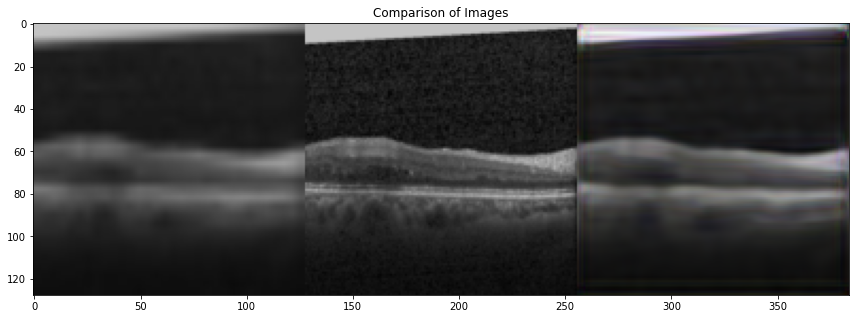

 30%|██████████████████████▊                                                     | 30/100 [1:32:11<3:32:24, 182.06s/it]

Epoch [31/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [31/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [31/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [31/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [31/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [31/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [31/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [31/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [31/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 31%|███████████████████████▌                                                    | 31/100 [1:35:16<3:30:20, 182.91s/it]

Epoch [32/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [32/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [32/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [32/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [32/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [32/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [32/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [32/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [32/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 32%|████████████████████████▎                                                   | 32/100 [1:38:17<3:26:31, 182.23s/it]

Epoch [33/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [33/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [33/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [33/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [33/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [33/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [33/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [33/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [33/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 33%|█████████████████████████                                                   | 33/100 [1:41:18<3:23:08, 181.91s/it]

Epoch [34/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [34/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [34/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [34/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [34/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [34/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [34/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [34/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [34/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 34%|█████████████████████████▊                                                  | 34/100 [1:44:19<3:19:54, 181.74s/it]

Epoch [35/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [35/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [35/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [35/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [35/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [35/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [35/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [35/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [35/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 35%|██████████████████████████▌                                                 | 35/100 [1:47:20<3:16:41, 181.55s/it]

Epoch [36/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [36/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [36/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [36/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [36/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [36/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [36/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [36/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [36/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 36%|███████████████████████████▎                                                | 36/100 [1:50:21<3:13:30, 181.42s/it]

Epoch [37/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [37/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [37/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [37/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [37/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [37/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [37/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [37/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [37/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 37%|████████████████████████████                                                | 37/100 [1:53:23<3:10:42, 181.62s/it]

Epoch [38/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [38/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [38/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [38/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [38/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [38/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [38/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [38/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [38/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 38%|████████████████████████████▉                                               | 38/100 [1:56:32<3:09:44, 183.62s/it]

Epoch [39/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [39/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [39/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [39/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [39/100], Batch [401/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [39/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [39/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [39/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [39/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 39%|█████████████████████████████▋                                              | 39/100 [1:59:36<3:06:48, 183.75s/it]

Epoch [40/100], Batch [1/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [40/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [40/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [40/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [40/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [40/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [40/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [40/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [40/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


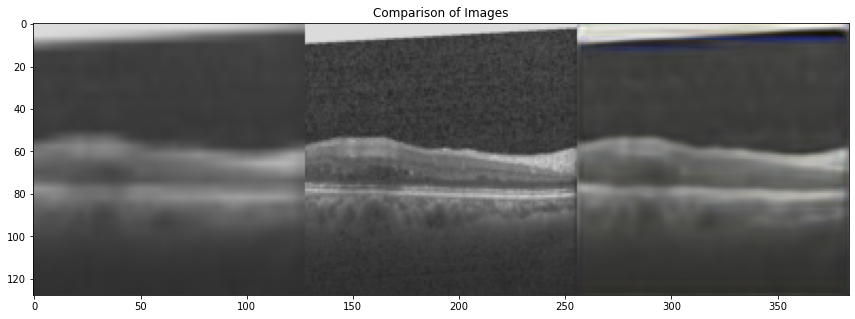

 40%|██████████████████████████████▍                                             | 40/100 [2:02:52<3:07:30, 187.50s/it]

Epoch [41/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [41/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [41/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [41/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [41/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [41/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [41/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [41/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [41/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 41%|███████████████████████████████▏                                            | 41/100 [2:05:53<3:02:37, 185.71s/it]

Epoch [42/100], Batch [1/837], Generator Loss: 100.0001, Discriminator Loss: 50.0000
Epoch [42/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [42/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [42/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [42/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [42/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [42/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [42/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [42/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 42%|███████████████████████████████▉                                            | 42/100 [2:08:55<2:58:11, 184.34s/it]

Epoch [43/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [43/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [43/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [43/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [43/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [43/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [43/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [43/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [43/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 43%|████████████████████████████████▋                                           | 43/100 [2:11:55<2:54:07, 183.29s/it]

Epoch [44/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [44/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [44/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [44/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [44/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [44/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [44/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [44/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [44/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 44%|█████████████████████████████████▍                                          | 44/100 [2:14:56<2:50:22, 182.55s/it]

Epoch [45/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [45/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [45/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [45/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [45/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [45/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [45/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [45/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [45/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 45%|██████████████████████████████████▏                                         | 45/100 [2:17:59<2:47:18, 182.51s/it]

Epoch [46/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [46/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [46/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [46/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [46/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [46/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [46/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [46/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [46/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 46%|██████████████████████████████████▉                                         | 46/100 [2:21:02<2:44:24, 182.67s/it]

Epoch [47/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [47/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [47/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [47/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [47/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [47/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [47/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [47/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [47/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 47%|███████████████████████████████████▋                                        | 47/100 [2:24:05<2:41:32, 182.88s/it]

Epoch [48/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [48/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [48/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [48/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [48/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [48/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [48/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [48/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [48/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 48%|████████████████████████████████████▍                                       | 48/100 [2:27:41<2:47:02, 192.73s/it]

Epoch [49/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [49/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [49/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [49/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [49/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [49/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [49/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [49/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [49/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 49%|█████████████████████████████████████▏                                      | 49/100 [2:31:05<2:46:51, 196.29s/it]

Epoch [50/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [50/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [50/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [50/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [50/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [50/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [50/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [50/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [50/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


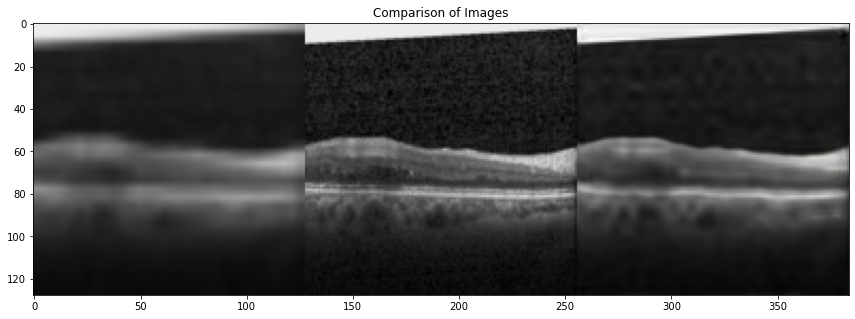

 50%|██████████████████████████████████████                                      | 50/100 [2:34:40<2:48:06, 201.74s/it]

Epoch [51/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [51/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [51/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [51/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [51/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [51/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [51/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [51/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [51/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 51%|██████████████████████████████████████▊                                     | 51/100 [2:37:41<2:39:46, 195.65s/it]

Epoch [52/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [52/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [52/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [52/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [52/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [52/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [52/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [52/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [52/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 52%|███████████████████████████████████████▌                                    | 52/100 [2:40:43<2:33:08, 191.42s/it]

Epoch [53/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [53/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [53/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [53/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [53/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [53/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [53/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [53/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [53/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 53%|████████████████████████████████████████▎                                   | 53/100 [2:43:44<2:27:31, 188.33s/it]

Epoch [54/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [54/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [54/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [54/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [54/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [54/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [54/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [54/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [54/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 54%|█████████████████████████████████████████                                   | 54/100 [2:46:45<2:22:43, 186.17s/it]

Epoch [55/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [55/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [55/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [55/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [55/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [55/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [55/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [55/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [55/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 55%|█████████████████████████████████████████▊                                  | 55/100 [2:49:46<2:18:31, 184.70s/it]

Epoch [56/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [56/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [56/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [56/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [56/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [56/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [56/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [56/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [56/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 56%|██████████████████████████████████████████▌                                 | 56/100 [2:52:47<2:14:29, 183.39s/it]

Epoch [57/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [57/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [57/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [57/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [57/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [57/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [57/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [57/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [57/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 57%|███████████████████████████████████████████▎                                | 57/100 [2:55:47<2:10:47, 182.50s/it]

Epoch [58/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [58/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [58/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [58/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [58/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [58/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [58/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [58/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [58/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 58%|████████████████████████████████████████████                                | 58/100 [2:58:47<2:07:14, 181.77s/it]

Epoch [59/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [59/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [59/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [59/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [59/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [59/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [59/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [59/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [59/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 59%|████████████████████████████████████████████▊                               | 59/100 [3:01:48<2:03:54, 181.33s/it]

Epoch [60/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [60/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [60/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [60/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [60/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [60/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [60/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [60/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [60/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


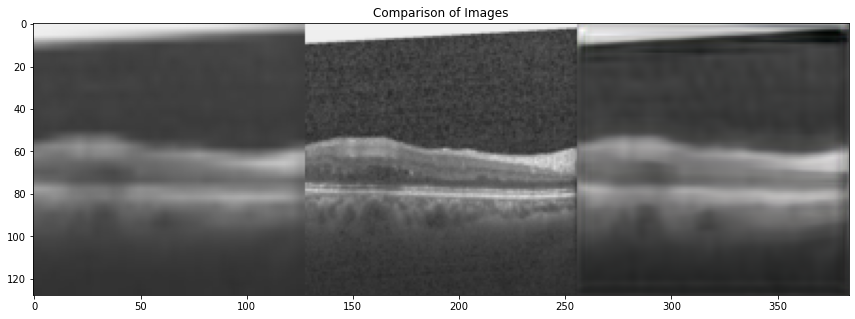

 60%|█████████████████████████████████████████████▌                              | 60/100 [3:04:49<2:00:56, 181.40s/it]

Epoch [61/100], Batch [1/837], Generator Loss: 100.0003, Discriminator Loss: 50.0000
Epoch [61/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [61/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [61/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [61/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [61/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [61/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [61/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [61/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 61%|██████████████████████████████████████████████▎                             | 61/100 [3:07:50<1:57:50, 181.30s/it]

Epoch [62/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [62/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [62/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [62/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [62/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [62/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [62/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [62/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [62/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 62%|███████████████████████████████████████████████                             | 62/100 [3:10:51<1:54:49, 181.31s/it]

Epoch [63/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [63/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [63/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [63/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [63/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [63/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [63/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [63/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [63/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 63%|███████████████████████████████████████████████▉                            | 63/100 [3:13:53<1:51:46, 181.24s/it]

Epoch [64/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [64/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [64/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [64/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [64/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [64/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [64/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [64/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [64/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 64%|████████████████████████████████████████████████▋                           | 64/100 [3:16:54<1:48:44, 181.24s/it]

Epoch [65/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [65/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [65/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [65/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [65/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [65/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [65/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [65/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [65/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 65%|█████████████████████████████████████████████████▍                          | 65/100 [3:19:55<1:45:44, 181.27s/it]

Epoch [66/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [66/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [66/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [66/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [66/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [66/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [66/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [66/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [66/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 66%|██████████████████████████████████████████████████▏                         | 66/100 [3:22:56<1:42:41, 181.22s/it]

Epoch [67/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [67/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [67/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [67/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [67/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [67/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [67/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [67/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [67/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 67%|██████████████████████████████████████████████████▉                         | 67/100 [3:25:58<1:39:40, 181.23s/it]

Epoch [68/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [68/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [68/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [68/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [68/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [68/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [68/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [68/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [68/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 68%|███████████████████████████████████████████████████▋                        | 68/100 [3:28:59<1:36:41, 181.30s/it]

Epoch [69/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [69/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [69/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [69/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [69/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [69/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [69/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [69/100], Batch [701/837], Generator Loss: 100.0024, Discriminator Loss: 50.0000
Epoch [69/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 69%|████████████████████████████████████████████████████▍                       | 69/100 [3:32:00<1:33:40, 181.29s/it]

Epoch [70/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [70/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [70/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [70/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [70/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [70/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [70/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [70/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [70/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


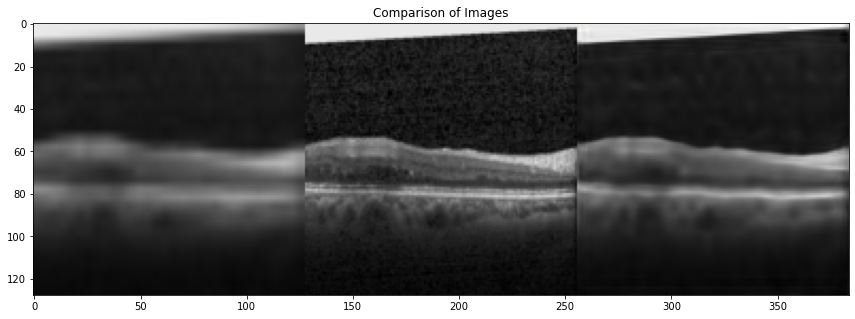

 70%|█████████████████████████████████████████████████████▏                      | 70/100 [3:35:02<1:30:42, 181.41s/it]

Epoch [71/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [71/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [71/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [71/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [71/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [71/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [71/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [71/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [71/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 71%|█████████████████████████████████████████████████████▉                      | 71/100 [3:38:04<1:27:43, 181.52s/it]

Epoch [72/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [72/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [72/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [72/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [72/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [72/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [72/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [72/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [72/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 72%|██████████████████████████████████████████████████████▋                     | 72/100 [3:41:05<1:24:38, 181.39s/it]

Epoch [73/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [73/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [73/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [73/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [73/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [73/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [73/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [73/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [73/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 73%|███████████████████████████████████████████████████████▍                    | 73/100 [3:44:07<1:21:40, 181.52s/it]

Epoch [74/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [74/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [74/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [74/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [74/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [74/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [74/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [74/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [74/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 74%|████████████████████████████████████████████████████████▏                   | 74/100 [3:47:08<1:18:39, 181.50s/it]

Epoch [75/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [75/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [75/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [75/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [75/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [75/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [75/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [75/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [75/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 75%|█████████████████████████████████████████████████████████                   | 75/100 [3:50:10<1:15:37, 181.49s/it]

Epoch [76/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [76/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [76/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [76/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [76/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [76/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [76/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [76/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [76/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 76%|█████████████████████████████████████████████████████████▊                  | 76/100 [3:53:10<1:12:31, 181.32s/it]

Epoch [77/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [77/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [77/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [77/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [77/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [77/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [77/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [77/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [77/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 77%|██████████████████████████████████████████████████████████▌                 | 77/100 [3:56:19<1:10:19, 183.48s/it]

Epoch [78/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [78/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [78/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [78/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [78/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [78/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [78/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [78/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [78/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 78%|███████████████████████████████████████████████████████████▎                | 78/100 [3:59:20<1:07:02, 182.82s/it]

Epoch [79/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [79/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [79/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [79/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [79/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [79/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [79/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [79/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [79/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 79%|████████████████████████████████████████████████████████████                | 79/100 [4:02:22<1:03:50, 182.38s/it]

Epoch [80/100], Batch [1/837], Generator Loss: 100.0008, Discriminator Loss: 50.0000
Epoch [80/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [80/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [80/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [80/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [80/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [80/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [80/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [80/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


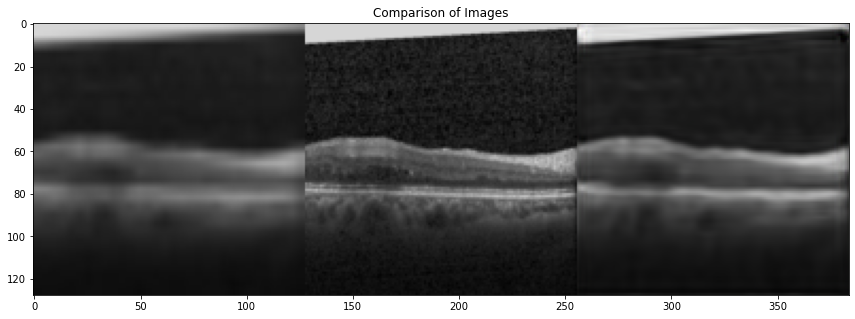

 80%|████████████████████████████████████████████████████████████▊               | 80/100 [4:05:23<1:00:43, 182.19s/it]

Epoch [81/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [81/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [81/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [81/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [81/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [81/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [81/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [81/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [81/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 81%|███████████████████████████████████████████████████████████████▏              | 81/100 [4:08:25<57:36, 181.92s/it]

Epoch [82/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [82/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [82/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [82/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [82/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [82/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [82/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [82/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [82/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 82%|███████████████████████████████████████████████████████████████▉              | 82/100 [4:11:26<54:29, 181.67s/it]

Epoch [83/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [83/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [83/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [83/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [83/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [83/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [83/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [83/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [83/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 83%|████████████████████████████████████████████████████████████████▋             | 83/100 [4:14:27<51:26, 181.55s/it]

Epoch [84/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [84/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [84/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [84/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [84/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [84/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [84/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [84/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [84/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 84%|█████████████████████████████████████████████████████████████████▌            | 84/100 [4:17:28<48:23, 181.44s/it]

Epoch [85/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [85/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [85/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [85/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [85/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [85/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [85/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [85/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [85/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 85%|██████████████████████████████████████████████████████████████████▎           | 85/100 [4:20:29<45:20, 181.39s/it]

Epoch [86/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [86/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [86/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [86/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [86/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [86/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [86/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [86/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [86/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 86%|███████████████████████████████████████████████████████████████████           | 86/100 [4:23:31<42:18, 181.29s/it]

Epoch [87/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [87/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [87/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [87/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [87/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [87/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [87/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [87/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [87/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 87%|███████████████████████████████████████████████████████████████████▊          | 87/100 [4:26:32<39:16, 181.30s/it]

Epoch [88/100], Batch [1/837], Generator Loss: 100.0068, Discriminator Loss: 50.0000
Epoch [88/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [88/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [88/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [88/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [88/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [88/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [88/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [88/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 88%|████████████████████████████████████████████████████████████████████▋         | 88/100 [4:29:33<36:14, 181.19s/it]

Epoch [89/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [89/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [89/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [89/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [89/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [89/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [89/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [89/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [89/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 89%|█████████████████████████████████████████████████████████████████████▍        | 89/100 [4:32:34<33:13, 181.23s/it]

Epoch [90/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [90/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [90/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [90/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [90/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [90/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [90/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [90/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [90/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


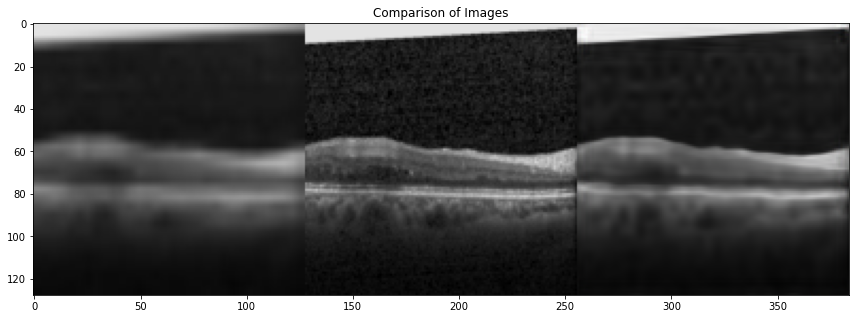

 90%|██████████████████████████████████████████████████████████████████████▏       | 90/100 [4:35:36<30:14, 181.42s/it]

Epoch [91/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [91/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [91/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [91/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [91/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [91/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [91/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [91/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [91/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 91%|██████████████████████████████████████████████████████████████████████▉       | 91/100 [4:38:37<27:11, 181.33s/it]

Epoch [92/100], Batch [1/837], Generator Loss: 100.0006, Discriminator Loss: 50.0000
Epoch [92/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [92/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [92/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [92/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [92/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [92/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [92/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [92/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 92%|███████████████████████████████████████████████████████████████████████▊      | 92/100 [4:41:38<24:10, 181.26s/it]

Epoch [93/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [93/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [93/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [93/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [93/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [93/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [93/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [93/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [93/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 93%|████████████████████████████████████████████████████████████████████████▌     | 93/100 [4:44:39<21:08, 181.21s/it]

Epoch [94/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [94/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [94/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [94/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [94/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [94/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [94/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [94/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [94/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 94%|█████████████████████████████████████████████████████████████████████████▎    | 94/100 [4:47:40<18:06, 181.12s/it]

Epoch [95/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [95/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [95/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [95/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [95/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [95/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [95/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [95/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [95/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 95%|██████████████████████████████████████████████████████████████████████████    | 95/100 [4:50:42<15:06, 181.26s/it]

Epoch [96/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [96/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [96/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [96/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [96/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [96/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [96/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [96/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [96/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 96%|██████████████████████████████████████████████████████████████████████████▉   | 96/100 [4:53:43<12:04, 181.21s/it]

Epoch [97/100], Batch [1/837], Generator Loss: 100.0009, Discriminator Loss: 50.0000
Epoch [97/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [97/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [97/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [97/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [97/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [97/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [97/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [97/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 97%|███████████████████████████████████████████████████████████████████████████▋  | 97/100 [4:56:44<09:03, 181.22s/it]

Epoch [98/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [98/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [98/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [98/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [98/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [98/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [98/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [98/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [98/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 98%|████████████████████████████████████████████████████████████████████████████▍ | 98/100 [4:59:45<06:02, 181.20s/it]

Epoch [99/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [99/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [99/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [99/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [99/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [99/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [99/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [99/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [99/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


 99%|█████████████████████████████████████████████████████████████████████████████▏| 99/100 [5:02:47<03:01, 181.30s/it]

Epoch [100/100], Batch [1/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [100/100], Batch [101/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [100/100], Batch [201/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [100/100], Batch [301/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [100/100], Batch [401/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [100/100], Batch [501/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [100/100], Batch [601/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [100/100], Batch [701/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000
Epoch [100/100], Batch [801/837], Generator Loss: 100.0000, Discriminator Loss: 50.0000


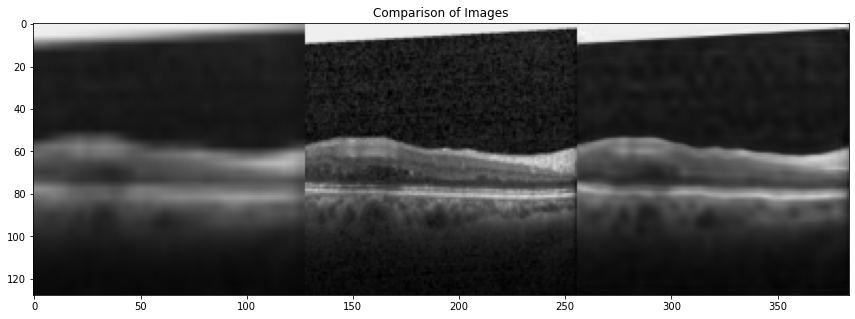

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [5:05:48<00:00, 183.49s/it]


In [20]:
D_losses, G_losses = [], []

for epoch in tqdm(range(num_epochs)):
    running_loss_G, running_loss_D, running_PSNR = 0, 0, 0
    for i, (lr_images, hr_images) in enumerate(trainLoader):
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        # Train the generator
        optimizer_G.zero_grad()

        sr_images = generator(lr_images)

        adversarial_loss = criterion_GAN(discriminator(sr_images), torch.ones(sr_images.size(0), 1).to(device))
        content_loss = criterion_content(sr_images, hr_images)

        total_loss_G = adversarial_loss + 0.01 * content_loss
        total_loss_G.backward()
        optimizer_G.step()

        # Train the discriminator
        optimizer_D.zero_grad()

        real_loss = criterion_GAN(discriminator(hr_images), torch.ones(hr_images.size(0), 1).to(device))
        fake_loss = criterion_GAN(discriminator(sr_images.detach()), torch.zeros(sr_images.size(0), 1).to(device))

        total_loss_D = (real_loss + fake_loss) / 2

        total_loss_D.backward()
        optimizer_D.step()

        # Print the loss every 100 iterations
        if i % 100 == 0:
            print('Epoch [{}/{}], Batch [{}/{}], Generator Loss: {:.4f}, Discriminator Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(trainLoader), total_loss_G.item(), total_loss_D.item()))
        
        running_loss_D += total_loss_D.item()
        running_loss_G += total_loss_G.item()

    epoch_loss_D = running_loss_D / len(trainLoader)
    epoch_loss_G = running_loss_G / len(trainLoader)
    
    D_losses.append(epoch_loss_D)
    G_losses.append(epoch_loss_G)
    
    if (epoch+1) % 1 == 0:
        torch.save(generator.state_dict(), 'generator_epoch{}.pth'.format(epoch+1))
        torch.save(discriminator.state_dict(), 'discriminator_epoch{}.pth'.format(epoch+1))
    if epoch == 0 or (epoch+1) % 10 == 0:
        with torch.no_grad():
            generator.eval()
            lr_image, hr_image = next(iter(valLoader))
            lr_image = lr_image.to(device)
            hr_image = hr_image.to(device)

            sr_image = generator(lr_image)
            example_image = torch.cat([lr_image, hr_image, sr_image], dim=3)
            example_image = make_grid(example_image, normalize=True, scale_each=True)
            example_image = np.transpose(example_image.cpu().detach().numpy(), (1, 2, 0))
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
            axs.imshow(example_image)
            axs.set_title('Comparison of Images')
            plt.show()
            generator.train()

Training stopped printing progress due to Jupyter Notebook limit being reached, 100 epochs were completed

## Save generated images into own dataset directory

In [46]:
class RetinaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['DME', 'DRUSEN']
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.images = []
        self.labels = []

        for cls_name in self.classes:
            cls_path = os.path.join(self.root_dir, 'train', cls_name)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.images.append(img_path)
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_filename = self.images[index]
        label = self.labels[index]
        class_name = self.classes[label]
        # Load the high-resolution image
        hr_img = Image.open(img_filename).convert('RGB')
        hr_transform = transforms.Resize((128, 128))
        hr_img_128 = hr_transform(hr_img)
        
        # Apply a transform to generate the low-resolution image
        lr_transform = transforms.Resize((32, 32))
        lr_img = lr_transform(hr_img)
        
        if self.transform:
            lr_img = self.transform(lr_img)
            hr_img_128 = self.transform(hr_img_128)
            
        return lr_img, hr_img_128, class_name

In [57]:
readDataset = RetinaDataset('Data', transform=SRGAN_transform)
trainLoader = DataLoader(readDataset, batch_size=1, shuffle=False)
for i, (lr_img, hr_img, label) in enumerate(trainLoader):
    lr_img = lr_img.to(device)
    
    sr_img = generator(lr_img)
    sr_img = sr_img.cpu().detach().numpy() * 255
    sr_img.squeeze()
    # print(sr_img.shape)
    sr_img = sr_img.astype('uint8').transpose((0, 2, 3, 1))
    # print(sr_img.shape)
    
    sr_img = sr_img[0]
    
    sr_img = Image.fromarray(sr_img)
    if not os.path.exists(f'/Users/stanl/Documents/GitHub/Biomedical_AI/Midterm/Generated/train/{label[0]}'):
        os.makedirs(f'/Users/stanl/Documents/GitHub/Biomedical_AI/Midterm/Generated/train/{label[0]}')
    sr_img.save(f'/Users/stanl/Documents/GitHub/Biomedical_AI/Midterm/Generated/train/{label[0]}/{i}.png')

## Train classifier from HW1 with SRGAN-generated dataset

In [58]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
import pandas as pd
import numpy as np

from datetime import datetime
import os

from tensorflow.python.client import device_lib
import tensorflow as tf
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17414423055998861227
xla_global_id: -1
]


In [63]:
# Setup
fold_num = 1

# Image Size
img_width, img_height, img_depth = 128, 128, 3
data_dir = Path('/Users/stanl/Documents/GitHub/Biomedical_AI/Midterm/Generated')
data_dir_train = data_dir / 'train'

epochs = 10
freq = 20
batch_size = 40
num_classes = 2
train_valid_split = 0.2

class_weights = {0: 2.,
                1: 1.,
                2: 1.}

if num_classes < 2:
    act_type = 'sigmoid'
    class_mode = 'binary'
    loss_fun = 'binary_crossentropy'
else:
    act_type = 'softmax'
    class_mode = 'categorical'
    loss_fun = 'categorical_crossentropy'
print('Type of classification: ', class_mode)
print('Loss function: ', loss_fun)
print('Activation function: ', act_type)

Type of classification:  categorical
Loss function:  categorical_crossentropy
Activation function:  softmax


*Explanation of hyperparameters*

Epochs: I first trained with 5 max epochs, which resulted in cutting off the max learning potential (loss was still decreasing). Increased to 10, which resulted in reaching close to absolute minimum.

Learning rate: Based on the example code given, I used the same learning rate as it performed well for this case based on the loss plot below. It may have been possible to get a smoother loss descent with a smaller learning rate, but that would require much more epochs.

Batch Size: With the default batch size of 32, my training worked well but the loss plot was quite eratic. Since I had more VRAM available, I increased the batch size to allow the calculated loss to encapsulate more data samples.

### 2: Data

In [64]:
img_height = 128
img_width = 128

# # Method 1: image_dataset_from_directory
# data_dir_DME = Path('/content/Data_Small/train/')
# train_df = tf.keras.utils.image_dataset_from_directory(
#     data_dir_DME,
#     validation_split=0.2,
#     subset="training",
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )
# val_df = tf.keras.utils.image_dataset_from_directory(
#     data_dir_DME,
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )

# Method 2: ImageDataGenerator
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 90,
    validation_split = 0.2,
    fill_mode = 'constant')

train_generator = datagen.flow_from_directory(
    directory = data_dir_train,
    class_mode = class_mode,
    batch_size = batch_size,
    target_size = (img_height, img_width),
    subset = "training")

valid_generator = datagen.flow_from_directory(
    directory = data_dir_train,
    class_mode = class_mode,
    batch_size = batch_size,
    target_size = (img_height, img_width),
    subset = "validation",
    shuffle = False)

Found 15290 images belonging to 2 classes.
Found 3822 images belonging to 2 classes.


In [65]:
class_names = train_generator.class_indices
print(class_names)

{'DME': 0, 'DRUSEN': 1}


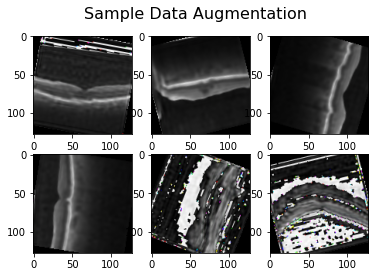

y Labels:  [[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
sample img, max value:  1.0
sample img, min value:  0.0


In [66]:
#For Directory
#Preview the augmented data
X_preview, y_preview = train_generator.next()

for k in range(1,7):
    sample_img = X_preview[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize = 16)    
plt.show()

print('y Labels: ', y_preview[1:5])
print('sample img, max value: ',np.max(sample_img))
print('sample img, min value: ',np.min(sample_img))

### 3: Training

##### Train your model using

In [22]:
# To prevent dataset bottleneck, keep images in memory and 
#   preprocess data while executing model during training
# AUTOTUNE = tf.data.AUTOTUNE
# train_df = train_df.cache().prefetch(buffer_size=AUTOTUNE)
# val_df = val_df.cache().prefetch(buffer_size=AUTOTUNE)

In [67]:
# Build model
image_input = Input(shape = (img_width, img_height, img_depth))
base_model = applications.vgg16.VGG16(input_tensor = image_input,
                                      include_top = False,
                                      weights = 'imagenet')
base_output = base_model.layers[-1].output

flat1 = Flatten()(base_output)
fc1 = Dense(8192, activation = 'relu')(flat1)
dropfc1 = Dropout(0.5)(fc1)
fc2 = Dense(4096, activation = 'relu')(dropfc1)
dropfc2 = Dropout(0.5)(fc2)

output = Dense(num_classes, activation = act_type)(dropfc2)

for layer in base_model.layers[:-9]:
  layer.trainable = False

model = Model(image_input, output)

58889256/58889256 [==============================] - 1s 0us/step


In [68]:
# Compile the model
opt = Adam(learning_rate = 0.00001)
model.compile(loss = loss_fun, optimizer = opt, metrics = ['accuracy'])

In [70]:
# Folder setup
init_time = datetime.now()
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = 'trained_models_' + current_time + '_fold_num' + str(fold_num)
os.mkdir(name_dir)

# Callbacks1: ModelCheckpointer
model_file_format = name_dir + '/model_' + str(fold_num) + '_model.{epoch:04d}.hdf5'
check = ModelCheckpoint(model_file_format, period = freq, verbose = 1)

# Callbacks2: TensorBoard
tensor_check = './logs/' + current_time + '_train_testsplit' + str(fold_num)
tensor_board = TensorBoard(tensor_check)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
# Plot model
figure_name = name_dir + '/model_output.png'
plot_model(model, figure_name, show_shapes = True)

model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 

In [71]:
history = model.fit_generator(train_generator,
                              epochs = epochs,
                              steps_per_epoch = train_generator.samples // batch_size,
                              validation_data = valid_generator,
                              validation_steps = valid_generator.samples // batch_size,
                              callbacks = [check, tensor_board],
                              class_weight = class_weights)

early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
model.save_weights(early_stop_name)
hist_df = pd.DataFrame(history.history)

C:\Users\stanl\AppData\Local\Temp\ipykernel_3788\469231994.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
382/382 [==============================] - 897s 2s/step - loss: 0.8254 - accuracy: 0.6528 - val_loss: 0.4825 - val_accuracy: 0.7532
Epoch 2/10
382/382 [==============================] - 886s 2s/step - loss: 0.4872 - accuracy: 0.8191 - val_loss: 0.3119 - val_accuracy: 0.8632
Epoch 3/10
382/382 [==============================] - 887s 2s/step - loss: 0.4219 - accuracy: 0.8502 - val_loss: 0.3000 - val_accuracy: 0.8597
Epoch 4/10
382/382 [==============================] - 912s 2s/step - loss: 0.3845 - accuracy: 0.8666 - val_loss: 0.3122 - val_accuracy: 0.8600
Epoch 5/10
382/382 [==============================] - 892s 2s/step - loss: 0.3612 - accuracy: 0.8721 - val_loss: 0.2656 - val_accuracy: 0.8889
Epoch 6/10
382/382 [==============================] - 884s 2s/step - loss: 0.3416 - accuracy: 0.8848 - val_loss: 0.2665 - val_accuracy: 0.8908
Epoch 7/10
382/382 [==============================] - 908s 2s/step - loss: 0.3294 - accuracy: 0.8882 - val_loss: 0.2968 - val_accuracy: 0.8658

In [73]:
model.save('/Users/stanl/Documents/GitHub/Biomedical_AI/Midterm/10epoch_model_Generated')

INFO:tensorflow:Assets written to: /Users/stanl/Documents/GitHub/Biomedical_AI/Midterm/10epoch_model_Generated\assets


INFO:tensorflow:Assets written to: /Users/stanl/Documents/GitHub/Biomedical_AI/Midterm/10epoch_model_Generated\assets


In [74]:
# Save history
# np.save('10epoch_hist.npy', history.history)
# history.history
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('/Users/stanl/Documents/GitHub/Biomedical_AI/Midterm/10epoch_hist_Generated.csv')

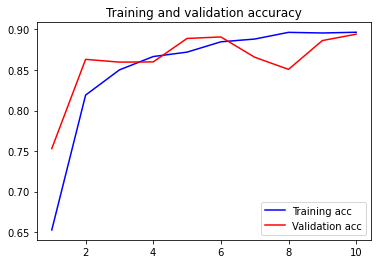

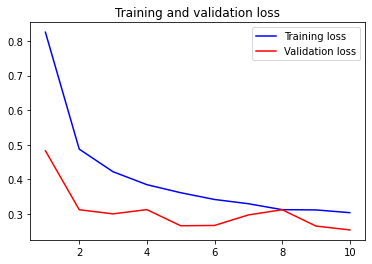

In [75]:
# Assign each loss/accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Confusion Matrix

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes#[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [77]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.2,
    rotation_range = 90,
    fill_mode = 'constant')

test_generator = test_datagen.flow_from_directory(
                              directory = data_dir_train,
                              target_size = (img_width, img_height),
                              class_mode = class_mode,
                              batch_size = batch_size)
X, y_true = [], []
i = 0
while i < 30:
    temp_X, temp_y_true = test_generator.next()
    if i < 1:
        X = temp_X
        y_true = temp_y_true
    else:
        X = np.concatenate((X, temp_X), axis=0)
        y_true = np.concatenate((y_true, temp_y_true), axis = 0)
    i += 1

print(np.shape(X))
print(np.shape(y_true))

y_pred = model.predict(X)

Found 19112 images belonging to 2 classes.
(1200, 128, 128, 3)
(1200, 2)
38/38 [==============================] - 26s 685ms/step


Categorical Classification
---------------------
Normalized confusion matrix
[[0.91988131 0.08011869]
 [0.15019011 0.84980989]]
[[620  54]
 [ 79 447]]


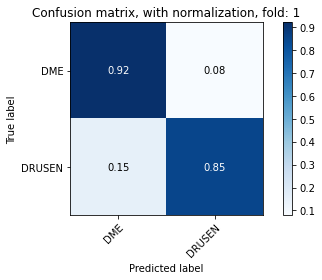

In [78]:
title_mat = 'Confusion matrix, with normalization, fold: ' + str(fold_num)
plot_name = name_dir + '/confusion_matrix_fold' + str(fold_num) + '.png'
print('Categorical Classification')
print('---------------------')
plot_confusion_matrix(y_true.argmax(axis=1),
                      y_pred.argmax(axis=1),
                      classes = class_names,
                      normalize = True,
                      title = title_mat)
plt.savefig(plot_name)
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

## Compare models' performance with F1, Accuracy, and AUC

In [84]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

In [87]:
hr_model_location = '/Users/stanl/Documents/GitHub/Biomedical_AI/Midterm/10epoch_model_HR.h5'
model_hr = tf.keras.models.load_model(hr_model_location)
sr_model_location = '/Users/stanl/Documents/GitHub/Biomedical_AI/Midterm/10epoch_model_Generated'
model_sr = tf.keras.models.load_model(sr_model_location)

model_hr.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_sr.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [99]:
test_datagen_hr = ImageDataGenerator(
    rescale=1./255,
    # horizontal_flip = True,
    # vertical_flip = True,
    # zoom_range = 0.2,
    # rotation_range = 90,
    # fill_mode = 'constant'
)

test_generator_hr = test_datagen.flow_from_directory(
                              directory = '/Users/stanl/Documents/GitHub/Biomedical_AI/Midterm/Data/train',
                              target_size = (img_width, img_height),
                              class_mode = class_mode,
                              batch_size = batch_size)

test_datagen_sr = ImageDataGenerator(
    rescale=1./255,
    # horizontal_flip = True,
    # vertical_flip = True,
    # zoom_range = 0.2,
    # rotation_range = 90,
    # fill_mode = 'constant'
)

test_generator_sr = test_datagen.flow_from_directory(
                              directory = data_dir_train,
                              target_size = (img_width, img_height),
                              class_mode = class_mode,
                              batch_size = batch_size)

Found 19112 images belonging to 2 classes.
Found 19112 images belonging to 2 classes.


In [100]:
# Import a blurred test datapoint to see performance differences
x_test_hr, y_test_hr = test_generator_hr.next()
y_pred_hr = model_hr.predict(x_test_hr)
y_pred_hr = (y_pred_hr > 0.5).astype(np.int32)

y_test_hr = np.argmax(y_test_hr, axis=1)
y_pred_hr = np.argmax(y_pred_hr, axis=1)
f1_hr = f1_score(y_test_hr, y_pred_hr)
acc_hr = accuracy_score(y_test_hr, y_pred_hr)
auc_hr = roc_auc_score(y_test_hr, y_pred_hr)

x_test_sr, y_test_sr = test_generator_sr.next()

y_pred_srgan = model_sr.predict(x_test_sr)
y_pred_srgan = (y_pred_srgan > 0.5).astype(np.int32)

y_test_sr = np.argmax(y_test_sr, axis=1)
y_pred_srgan = np.argmax(y_pred_srgan, axis=1)
f1_srgan = f1_score(y_test_sr, y_pred_srgan)
acc_srgan = accuracy_score(y_test_sr, y_pred_srgan)
auc_srgan = roc_auc_score(y_test_sr, y_pred_srgan)

2/2 [==============================] - 1s 197ms/step


In [101]:
print("High-resolution model F1 score: ", f1_hr)
print("High-resolution model accuracy score: ", acc_hr)
print("High-resolution model AUC score: ", auc_hr)

print("SRGAN model F1 score: ", f1_srgan)
print("SRGAN model accuracy score: ", acc_srgan)
print("SRGAN model AUC score: ", auc_srgan)

High-resolution model F1 score:  0.8387096774193548
High-resolution model accuracy score:  0.875
High-resolution model AUC score:  0.8611111111111112
SRGAN model F1 score:  0.896551724137931
SRGAN model accuracy score:  0.925
SRGAN model AUC score:  0.90625


In [105]:
# Lets flip their inputs to see how they perform on each other's data
x_test_sr, y_test_sr = test_generator_sr.next()
y_pred_hr = model_hr.predict(x_test_sr) # Changed x_test_hr to x_test_sr
y_pred_hr = (y_pred_hr > 0.5).astype(np.int32)

y_test_hr = np.argmax(y_test_sr, axis=1) # Changed y_test_hr to y_test_sr
y_pred_hr = np.argmax(y_pred_hr, axis=1)
f1_hr = f1_score(y_test_hr, y_pred_hr)
acc_hr = accuracy_score(y_test_hr, y_pred_hr)
auc_hr = roc_auc_score(y_test_hr, y_pred_hr)

x_test_hr, y_test_hr = test_generator_hr.next()
y_pred_srgan = model_sr.predict(x_test_hr) # Changed x_test_sr to x_test_hr
y_pred_srgan = (y_pred_srgan > 0.5).astype(np.int32)

y_test_sr = np.argmax(y_test_hr, axis=1) # Changed y_test_sr to y_test_hr
y_pred_srgan = np.argmax(y_pred_srgan, axis=1)
f1_srgan = f1_score(y_test_sr, y_pred_srgan)
acc_srgan = accuracy_score(y_test_sr, y_pred_srgan)
auc_srgan = roc_auc_score(y_test_sr, y_pred_srgan)

2/2 [==============================] - 1s 192ms/step


In [106]:
print("High-resolution model F1 score: ", f1_hr)
print("High-resolution model accuracy score: ", acc_hr)
print("High-resolution model AUC score: ", auc_hr)

print("SRGAN model F1 score: ", f1_srgan)
print("SRGAN model accuracy score: ", acc_srgan)
print("SRGAN model AUC score: ", auc_srgan)

High-resolution model F1 score:  0.7777777777777778
High-resolution model accuracy score:  0.8
High-resolution model AUC score:  0.7979797979797979
SRGAN model F1 score:  0.9375
SRGAN model accuracy score:  0.95
SRGAN model AUC score:  0.9479166666666667
